#  Data Wrangling and Analyzing on "We Rate Dogs" Twitter Site
by Dilupa Chandrasekara

## Data Gathering

1. Twitter Archive File : Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)
2. The tweet image predictions - what breed of dog (or other things) is present in each tweet according to a neural network(Previously done and tested). This file (image_predictions.tsv) is hosted on Udacity's servers and needed to be downloaded programmatically using the Requests library and the following URL -https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

3. Twitter API & JSON - Each tweet's found in the We rate dogs we retweet count and favorite ("like") count at minimum. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

1. Twitter Archive File

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests 
import seaborn as sns
import time



In [2]:
#Read CSV file 
df = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

2. Uses the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
import requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
data = requests.get(url)
with open (url.split('/')[-1], mode='wb') as file:
    file.write(data.content)

In [6]:
image_data = pd.read_csv('image-predictions.tsv', sep='\t')
image_data.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
#!pip install  --upgrade tweepy==4.6

3. Uses the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [8]:
import tweepy

bearer_token='AAAAAAAAAAAAAAAAAAAAAMPpYwEAAAAAHYmhw4BflEGucKBU4ZBlQFjMVn0%3DMMIPovZjtqjof7qGLBpNZAOus8JxB6wky7w4Hba08CMIOQw2Nu'
# create instance
client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

# fields to return in query
tweet_fields=["id","in_reply_to_user_id","favourite_count", "retweet_count", "retweet_status","lang",
    "public_metrics","source","text"]
# query

tweet_id_list = df['tweet_id']

tweet_field = ["id","in_reply_to_user_id","lang",
    "public_metrics","source","text"]
public_metrics_list = []

for tweet_id in tweet_id_list:
        tweet_dict={}
        temp = client.get_tweet(id=tweet_id, tweet_fields =tweet_field)
        tweet_data = temp.data
        for key in tweet_field:
            if tweet_data and tweet_data.get(key):
                tweet_dict[key]=tweet_data[key]
            else:
                print(f'Empty tweet: {tweet_id}, tweet info: {tweet_data}')
            
        public_metrics_list.append(tweet_dict)
        

Empty tweet: 892420643555336193, tweet info: This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
Empty tweet: 892177421306343426, tweet info: This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
Empty tweet: 891815181378084864, tweet info: This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
Empty tweet: 891689557279858688, tweet info: This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
Empty tweet: 891327558926688256, tweet info: This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
Empty tweet: 891087950875897856, tweet info: Here we have a majestic great white breachin

Empty tweet: 883117836046086144, tweet info: Please only send dogs. We don't rate mechanics, no matter how h*ckin good. Thank you... 13/10 would sneak a pat https://t.co/Se5fZ9wp5E
Empty tweet: 882992080364220416, tweet info: This is Rusty. He wasn't ready for the first pic. Clearly puppared for the second. 13/10 confirmed great boy https://t.co/tyER0KpdXj
Empty tweet: 882762694511734784, tweet info: This is Gus. He's quite the cheeky pupper. Already perfected the disinterested wink. 12/10 would let steal my girl https://t.co/D43I96SlVu
Empty tweet: 882627270321602560, tweet info: This is Stanley. He has his first swim lesson today. Doggle straps adjusted. Ready to go. 13/10 Phelps is nervous (IG: stanleythe_corgi) https://t.co/Nx52PGwH94
Empty tweet: 882268110199369728, tweet info: This is Alfy. You're witnessing his first watermelon experience. I think it was a success. 13/10 happy 4th Alfy 🇺🇸 https://t.co/fYP5RlutfA
Empty tweet: 882045870035918850, tweet info: This is Koko. Her owne

Empty tweet: 873697596434513921, tweet info: None
Empty tweet: 873697596434513921, tweet info: None
Empty tweet: 873697596434513921, tweet info: None
Empty tweet: 873697596434513921, tweet info: None
Empty tweet: 873697596434513921, tweet info: None
Empty tweet: 873697596434513921, tweet info: None
Empty tweet: 873580283840344065, tweet info: We usually don't rate Deck-bound Saskatoon Black Bears, but this one is h*ckin flawless. Sneaky tongue slip too. 13/10 would hug firmly https://t.co/mNuMH9400n
Empty tweet: 873337748698140672, tweet info: RT @dog_rates: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below

https:/…
Empty tweet: 873213775632977920, tweet info: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below

https://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ
Empty tweet: 872967104147763200, tweet info: Here's a very large dog. He has a date later. Politely

Empty tweet: 865718153858494464, tweet info: Meet Boomer. He's just checking pup on you. Hopes you had a good day. If not, he hopes he made it better. 13/10 extremely good boy https://t.co/pozUoHLkGg
Empty tweet: 865359393868664832, tweet info: This is Sammy. Her tongue ejects without warning sometimes. It's a serious condition. Needs a hefty dose from a BlepiPen. 13/10 https://t.co/g20EmqK7vc
Empty tweet: 865006731092295680, tweet info: This is Nelly. He really hopes you like his Hawaiian shirt. He already tore the tags off. 13/10 h*ck of a puppurchase https://t.co/LbkG5CiM7o
Empty tweet: 864873206498414592, tweet info: We only rate dogs. Please don't send in Jesus. We're trying to remain professional and legitimate. Thank you... 14/10 https://t.co/wr3xsjeCIR
Empty tweet: 864279568663928832, tweet info: This is Meatball. He doing what's known in the industry as a mid-strut mlem. H*ckin fancy boy. 12/10 I'd do anything for Meatball https://t.co/S2HdmFFPck
Empty tweet: 86419739836464742

Empty tweet: 856330835276025856, tweet info: None
Empty tweet: 856330835276025856, tweet info: None
Empty tweet: 856330835276025856, tweet info: None
Empty tweet: 856330835276025856, tweet info: None
Empty tweet: 856330835276025856, tweet info: None
Empty tweet: 856330835276025856, tweet info: None
Empty tweet: 856282028240666624, tweet info: This is Cermet, Paesh, and Morple. They are absolute h*ckin superstars. Watered every day so they can grow. 14/10 for all https://t.co/GUefqUmZv8
Empty tweet: 855857698524602368, tweet info: HE'S LIKE "WAIT A MINUTE I'M AN ANIMAL THIS IS AMAZING HI HUMAN I LOVE YOU AS WELL" 13/10 https://t.co/sb73bV5Y7S
Empty tweet: 855851453814013952, tweet info: Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
Empty tweet: 855818117272018944, tweet info: I HEARD HE TIED HIS OWN BOWTIE MARK AND HE JUST WANTS TO SAY HI AND MAYBE A NOGGIN PAT SHOW SOME RESP

Empty tweet: 847971574464610304, tweet info: RT @basic_vacek_: I love my new mug easy 13/10 @dog_rates https://t.co/0bYtoL7Wwt
Empty tweet: 847962785489326080, tweet info: This is Georgie. He's very shy. Only puppears when called. Aggressively average at fetch. Unique front paws. Looks slippery. 10/10 would pet https://t.co/rcDs5LkiSj
Empty tweet: 847842811428974592, tweet info: This is Rontu. He is described as a pal, cuddle bug, protector and constant shadow. 12/10, but he needs your help

https://t.co/zK4cpKPFfU https://t.co/7Xvoalr798
Empty tweet: 847606175596138505, tweet info: This is Cannon. He just heard something behind him. Fr*ckin frightened af. 12/10 don't look back just run https://t.co/WTPBWT6Ux1
Empty tweet: 847251039262605312, tweet info: This is Furzey. He's doing an elevated sandy zoom. Adjusts ears to steer. 12/10 would pet mid flight https://t.co/zhbRIZQgnq
Empty tweet: 847157206088847362, tweet info: Meet Daisy. She's been pup for adoption for months now but hasn't

Empty tweet: 839990271299457024, tweet info: Meet Sojourner. His nose is a Fibonacci Spiral. Legendary af. 13/10 we must protect him at all costs https://t.co/r7W1NbkOtr
Empty tweet: 839549326359670784, tweet info: Meet Winston. He knows he's a little too big for the swing, but he doesn't care. Kindly requests a push. 12/10 would happily oblige https://t.co/GuxEXTdnMu
Empty tweet: 839290600511926273, tweet info: RT @alexmartindawg: THE DRINK IS DR. PUPPER 10/10 good pun @matt___nelson @GoodDogsGame https://t.co/act3duiqbL
Empty tweet: 839239871831150596, tweet info: This is Odie. He's big. 13/10 would attempt to ride https://t.co/JEXB9RwBmm
Empty tweet: 838952994649550848, tweet info: SHE MISPLACED HER HOOMAN 13/10 MISTAKES HAPPEN https://t.co/ngAxYLVYHP
Empty tweet: 838921590096166913, tweet info: This is Arlo. He's officially the king of snowy tongue slips. 13/10 would comfort during inevitable brain freeze https://t.co/oXVu9pNZZv
Empty tweet: 838916489579200512, tweet info: RT @Kiba

Rate limit exceeded. Sleeping for 848 seconds.


Empty tweet: 836753516572119041, tweet info: This is Meera. She just heard about taxes and how much a doghouse in a nice area costs. Not pupared to be a  doggo anymore. 12/10 https://t.co/GZmNEdyoJY
Empty tweet: 836677758902222849, tweet info: Say hello to Oliver. He's pretty exotic. Fairly pupset as well. Too many midterms coming pup. 11/10 would pet with extreme caution https://t.co/fGAPAsxjKs
Empty tweet: 836648853927522308, tweet info: RT @SchafeBacon2016: @dog_rates Slightly disturbed by the outright profanity, but confident doggos were involved. 11/10, would tailgate aga…
Empty tweet: 836397794269200385, tweet info: RT @dog_rates: This is Buddy. He ran into a glass door once. Now he's h*ckin skeptical. 13/10 empowering af (vid by Brittany Gaunt) https:/…
Empty tweet: 836380477523124226, tweet info: This is Ava. She just blasted off. Streamline af. Aerodynamic as h*ck. One small step for pupper, one giant leap for pupkind. 12/10 https://t.co/W4KffrdX3Q
Empty tweet: 836260088725786

Empty tweet: 831670449226514432, tweet info: This is Daisy. She has a heart on her butt. 13/10 topical af https://t.co/u6p4LxzHKg
Empty tweet: 831650051525054464, tweet info: I usually only share these on Friday's, but this is Blue. He's a very smoochable pooch who needs your help. 13/10

https://t.co/piiX0ke8Z6 https://t.co/1UHrKcaCiO
Empty tweet: 831552930092285952, tweet info: This is Dutch. He dressed up as his favorite emoji for Valentine's Day. I've got heart eyes for his heart eyes. 13/10 https://t.co/BCbmFYLrse
Empty tweet: 831322785565769729, tweet info: This is Pete. He has no eyes. Needs a guide doggo. Also appears to be considerably fluffy af. 12/10 would hug softly https://t.co/Xc0gyovCtK
Empty tweet: 831315979191906304, tweet info: I couldn't make it to the #WKCDogShow BUT I have people there on the ground relaying me the finest pupper pics possible. 13/10 for all https://t.co/jd6lYhfdH4
Empty tweet: 831309418084069378, tweet info: This is Scooter and his son Montoya.  Sc

Empty tweet: 825876512159186944, tweet info: This is Mo. No one will push him around in the grocery cart. He's quite pupset about it. 11/10 I volunteer https://t.co/feNwTq12S5
Empty tweet: 825829644528148480, tweet info: This is Toby. He just found out you only pretend to throw the ball sometimes. H*ckin puppalled. 12/10 would console https://t.co/YimNdkZrhM
Empty tweet: 825535076884762624, tweet info: Here's a very loving and accepting puppo. Appears to have read her Constitution well. 14/10 would pat head approvingly https://t.co/6ao80wIpV1
Empty tweet: 825147591692263424, tweet info: This is Sweet Pea. She hides in shoe boxes and waits for someone to pick her. Then she surpuprises them. 13/10 https://t.co/AyBEmx56MD
Empty tweet: 825120256414846976, tweet info: RT @dog_rates: Say hello to Pablo. He's one gorgeous puppo. A true 12/10. Click the link to see why Pablo requests your assistance

https:/…
Empty tweet: 825026590719483904, tweet info: Say hello to Pablo. He's one gorgeous pu

Empty tweet: 819588359383371776, tweet info: This is Jazzy. She just found out that sandwich wasn't for her. Shocked and puppalled. 13/10 deep breaths Jazzy https://t.co/52cItP0vIO
Empty tweet: 819347104292290561, tweet info: Say hello to Anna and Elsa. They fall asleep in similar positions. It's pretty wild. Both 12/10 would snug simultaneously https://t.co/8rUL99bX4W
Empty tweet: 819238181065359361, tweet info: Some happy pupper news to share. 10/10 for everyone involved 
https://t.co/MefMAZX2uv
Empty tweet: 819227688460238848, tweet info: This is Finn. He's wondering if you come here often. Fr*ckin flirtatious af. 12/10 would give number to https://t.co/ii5eNX5LJT
Empty tweet: 819015337530290176, tweet info: RT @dog_rates: This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1
Empty tweet: 819015331746349057, tweet info: RT @dog_rates: This is Sunny. She was also a very good First Doggo. 14/10 would also be an absolute honor to pe

Empty tweet: 813217897535406080, tweet info: Here is Atlas. He went all out this year. 13/10 downright magical af https://t.co/DVYIZOnO81
Empty tweet: 813202720496779264, tweet info: Here's a doggo who has concluded that Christmas is entirely too bright. Requests you tone it down a notch. 11/10 https://t.co/cD967DjnIn
Empty tweet: 813187593374461952, tweet info: We only rate dogs. Please don't send in other things like this very good Christmas tree. Thank you... 13/10 https://t.co/rvSANEsQZJ
Empty tweet: 813172488309972993, tweet info: This is Eleanor. She winks like she knows many things that you don't. 12/10 https://t.co/bxGwkJa2kE
Empty tweet: 813157409116065792, tweet info: This is Layla. It is her first Christmas. She got to be one of the presents. 12/10 I wish my presents would bark https://t.co/hwhCbhCjnV
Empty tweet: 813142292504645637, tweet info: Everybody stop what you're doing and look at this dog with her tiny Santa hat. 13/10 https://t.co/KK4XQK9SPi
Empty tweet: 813127251

Empty tweet: 806219024703037440, tweet info: We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi
Empty tweet: 805958939288408065, tweet info: RT @dog_rates: This is Penny. She fought a bee and the bee won. 10/10 you're fine Penny, everything's fine https://t.co/zrMVdfFej6
Empty tweet: 805932879469572096, tweet info: This is Major. He put on a tie for his first real walk. Only a little crooked. Can also drool upwards. H*ckin talented. 12/10 https://t.co/Zcwr8LgoO8
Empty tweet: 805826884734976000, tweet info: This is Duke. He is not a fan of the pupporazzi. 12/10 https://t.co/SgpBVYIL18
Empty tweet: 805823200554876929, tweet info: RT @dog_rates: This is Reginald. He's one magical puppo. Aerodynamic af. 12/10 would catch https://t.co/t0cEeRbcXJ
Empty tweet: 805520635690676224, tweet info: This is Zeke the Wonder Dog. He never let that poor man keep his frisbees. One of the Spartans all time gre

Empty tweet: 798697898615730177, tweet info: RT @dog_rates: This is Stubert. He just arrived. 10/10 https://t.co/HVGs5aAKAn
Empty tweet: 798694562394996736, tweet info: RT @dog_rates: I'm not sure what's happening here, but it's pretty spectacular. 12/10 for both https://t.co/JKXh0NbBNL
Empty tweet: 798686750113755136, tweet info: RT @dog_rates: Say hello to Jack (pronounced "Kevin"). He's a Virgo Episcopalian. Can summon rainbows. 11/10 magical as hell https://t.co/Y…
Empty tweet: 798682547630837760, tweet info: RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.…


Rate limit exceeded. Sleeping for 846 seconds.


Empty tweet: 798673117451325440, tweet info: RT @dog_rates: I shall call him squishy and he shall be mine, and he shall be my squishy. 13/10 https://t.co/WId5lxNdPH
Empty tweet: 798665375516884993, tweet info: RT @dog_rates: This is Lola. She fell asleep on a piece of pizza. 10/10 frighteningly relatable https://t.co/eqmkr2gmPH
Empty tweet: 798644042770751489, tweet info: RT @dog_rates: This is Paull. He just stubbed his toe. 10/10 deep breaths Paull https://t.co/J5Mqn8VeYq
Empty tweet: 798628517273620480, tweet info: RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7
Empty tweet: 798585098161549313, tweet info: RT @dog_rates: This is Timison. He just told an awful joke but is still hanging on to the hope that you'll laugh with him. 10/10 https://t.…
Empty tweet: 798576900688019456, tweet info: RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shit

Empty tweet: 792394556390137856, tweet info: Meet BeBe. She rocks the messy bun of your dreams. H*ckin flawless. 12/10 would watch her tutorial https://t.co/of0pFNBIl8
Empty tweet: 792050063153438720, tweet info: This is Remus. He's a mop that came to life. Can't see anything. Constantly trips over himself. Still a very good dog. 11/10 https://t.co/S3f1SYylzu
Empty tweet: 791821351946420224, tweet info: RT @dog_rates: This little fella really hates stairs. Prefers bush. 13/10 legendary pupper https://t.co/e3LPMAHj7p
Empty tweet: 791784077045166082, tweet info: RT @dog_rates: I'm not sure what this dog is doing but it's pretty inspirational. 12/10 https://t.co/4Kn9GEHXiE
Empty tweet: 791780927877898241, tweet info: RT @dog_rates: This is Maddie. She gets some wicked air time. Hardcore barkour. 11/10 nimble af https://t.co/bROYbceZ1u
Empty tweet: 791774931465953280, tweet info: Vine will be deeply missed. This was by far my favorite one. 14/10 https://t.co/roqIxCvEB3
Empty tweet: 7916723

Empty tweet: 785533386513321988, tweet info: This is Dallas. Her tongue is ridiculous. 11/10 h*ckin proud af https://t.co/h4jhlH4EyG
Empty tweet: 785515384317313025, tweet info: Today, 10/10, should be National Dog Rates Day
Empty tweet: 785264754247995392, tweet info: This is Doc. He requested to be carried around like that. 12/10 anything for Doc https://t.co/mWYACm4qnx
Empty tweet: 785170936622350336, tweet info: This is Hero. He was enjoying the car ride until he remembered that bees are dying globally at an alarming rate. 11/10 https://t.co/cubFg7F4qQ
Empty tweet: 784826020293709826, tweet info: This is Rusty. He's going D1 for sure. Insane vertical. 13/10 would draft https://t.co/AsykOwMrXQ
Empty tweet: 784517518371221505, tweet info: This is Frankie. He has yet to learn how to control his tongue. 11/10 maybe one day https://t.co/p6fgYe2dB6
Empty tweet: 784431430411685888, tweet info: This is Stormy. He's curly af. Already pupared for Coachella next year. 12/10 https://t.co/PHA1v

Empty tweet: 778748913645780993, tweet info: This is Mya (pronounced "mmmyah?"). Her head is round af. 11/10 would pat accordingly https://t.co/1dpEuALnY0
Empty tweet: 778650543019483137, tweet info: Meet Strider. He thinks he's a sorority girl. Already wants to go to NYC for a weekend to say he's "studied abroad" 10/10 https://t.co/KYZkPuiC1l
Empty tweet: 778624900596654080, tweet info: This is Penny. She's a sailor pup. 11/10 would take to the open seas with https://t.co/0rRxyBQt32
Empty tweet: 778408200802557953, tweet info: RIP Loki. Thank you for the good times. You will be missed by many. 14/10 https://t.co/gJKD9pst5A
Empty tweet: 778396591732486144, tweet info: RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR
Empty tweet: 778383385161035776, tweet info: This is Nala. She's a future Dogue model. Won't respond to my texts. 13/10 would be an honor to pet https://t.co/zP1IvAATWv
Empty tweet: 

Empty tweet: 772152991789019136, tweet info: Here's a couple rufferees making sure all the sports are played fairly today. Both 10/10 would bribe with extra pets https://t.co/H9yjI9eo3A
Empty tweet: 772117678702071809, tweet info: Meet Jack. He's a Clemson pup. Appears to be rather h*ckin pettable. Almost makes me want to root for Clemson. 12/10 https://t.co/GHOfbTVQti
Empty tweet: 772114945936949249, tweet info: This is Finn. He's very nervous for the game. Has a lot of money riding on it.10/10 would attempt to comfort https://t.co/CbtNfecWiT
Empty tweet: 772102971039580160, tweet info: This is Penny. She's an OU cheerleader. About to do a triple back handspring down the stairs. 11/10 hype af https://t.co/B2f3XkGU5c
Empty tweet: 771908950375665664, tweet info: Doggo will persevere. 13/10
https://t.co/yOVzAomJ6k
Empty tweet: 771770456517009408, tweet info: This is Davey. He'll have your daughter home by 8. Just a stand up pup. 11/10 would introduce to mom https://t.co/E6bGWf9EOm
Empty 

Empty tweet: 765669560888528897, tweet info: This is Tove. She's a Balsamic Poinsetter. Surprisingly deadly. 12/10 snug with caution https://t.co/t6RvnVEdRR
Empty tweet: 765395769549590528, tweet info: This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB
Empty tweet: 765371061932261376, tweet info: This is Louie. He's had a long day. Did a lot of pupper things. Also appears to be rather heckin pettable. 11/10 https://t.co/w2qDmoTIZ5
Empty tweet: 765222098633691136, tweet info: This is Gromit. He's pupset because there's no need to beware of him. Just wants a pettin. 10/10 https://t.co/eSvz4EapHH
Empty tweet: 764857477905154048, tweet info: This is Aubie. He has paws for days. Nibbling tables is one of his priorities. Second only to being cuddly af. 12/10 https://t.co/cBIFBsCRz6
Empty tweet: 764259802650378240, tweet info: This is Kota and her son Benedict. She doesn't know why you're staring. They are a n

Rate limit exceeded. Sleeping for 845 seconds.


Empty tweet: 758828659922702336, tweet info: This doggo is just waiting for someone to be proud of her and her accomplishment. 13/10 legendary af https://t.co/9T2h14yn4Q
Empty tweet: 758740312047005698, tweet info: Meet Boston. He's worried because his tongue won't fit all the way in his mouth. 12/10 it'll be ok deep breaths pup https://t.co/rfWQ4T9iQj
Empty tweet: 758474966123810816, tweet info: This is Brandonald. He accidentally opened the front facing camera. Playing it off rather heckin well. 11/10 https://t.co/uPUAotqQtM
Empty tweet: 758467244762497024, tweet info: Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
Empty tweet: 758405701903519748, tweet info: This is Odie. He falls asleep wherever he wants. Must be nice. 10/10 https://t.co/M9BXCSDVjh
Empty tweet: 758355060040593408, tweet info: This is Corey. He's a Portobello Corgicool. Trying to convince you that he's not a hipster. 11/10 yea right Corey https://t.co/NzWUrFZydr
Empty tweet: 758099635

Empty tweet: 752173152931807232, tweet info: This is Brody. He's a lifeguard. Always prepared for rescue. 12/10 would fake drown just to get saved by him https://t.co/olDmwNjOy1
Empty tweet: 751950017322246144, tweet info: This is Lola. She's a surfing pupper. 13/10 magical af https://t.co/BlGQkhM5EV
Empty tweet: 751937170840121344, tweet info: This is Ruby. Her ice cube is melting. She doesn't know what to do about it. 11/10 https://t.co/Vfc3eAFl2q
Empty tweet: 751830394383790080, tweet info: This is Tucker. He's very camera shy. 12/10 would give stellar belly rubs to https://t.co/BJRsxuLF1w
Empty tweet: 751793661361422336, tweet info: This is Fred. He's having one heck of a summer. 11/10 https://t.co/I7SFchkNk4
Empty tweet: 751598357617971201, tweet info: This is Toby. A cat got his tongue. 13/10 adorable af https://t.co/fHQrBKYSLC
Empty tweet: 751583847268179968, tweet info: Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch 

Empty tweet: 747844099428986880, tweet info: This is Huxley. He's pumped for #BarkWeek. Even has a hat. Ears are quite magical. 11/10 would remove hat to pat https://t.co/V7h5NMYbYz
Empty tweet: 747816857231626240, tweet info: Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R
Empty tweet: 747648653817413632, tweet info: This is Keurig. He apparently headbutts other dogs to greet them. Not cool Keurig. So fluffy tho 12/10  https://t.co/zexdr61Q5M
Empty tweet: 747600769478692864, tweet info: This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ
Empty tweet: 747594051852075008, tweet info: Again w the sharks guys. This week is about dogs ACTING or DRESSING like sharks. NOT actual sharks. Thank u ...11/10 https://t.co/Ie2mWXWjpr
Empty tweet: 747512671126323200, tweet info: Guys pls stop sending actual sharks. It's too dangerous 

Empty tweet: 742385895052087300, tweet info: This is Phil. That's his comfort stick. He holds onto it whenever he's sad. 11/10 don't be sad Phil https://t.co/ULdPY6CLpq
Empty tweet: 742161199639494656, tweet info: This is Doug. He's trying to float away. 12/10 you got this Doug https://t.co/bZaHC3lvTL
Empty tweet: 742150209887731712, tweet info: This is Edmund. He sends stellar selfies. Cute af. 8/10 would totally snapchat with this pupper https://t.co/PprXoqZuKY
Empty tweet: 741793263812808706, tweet info: When your crush won't pay attention to you. Both 10/10 tragic af https://t.co/d3LELGVlqu
Empty tweet: 741743634094141440, tweet info: Meet Aqua. She's a sandy pupper. Not sure how she feels about being so sandy. Radical tongue slip. 11/10 petable af https://t.co/rYxJ0UQtbE
Empty tweet: 741438259667034112, tweet info: This is Tucker. He's still figuring out couches. 9/10 keep your head up pup https://t.co/pXU77HPbJ5
Empty tweet: 741303864243200000, tweet info: This is Theodore. He ju

Empty tweet: 734776360183431168, tweet info: This is Livvie. Someone should tell her it's been 47 years since Woodstock. Magical eyes tho 11/10 would stare into https://t.co/qw07vhVHuO
Empty tweet: 734559631394082816, tweet info: When your friend is turnt af and you're just trying to chill. 10/10 (vid by @presgang) https://t.co/OufVDk23JC
Empty tweet: 733828123016450049, tweet info: This is Terry. The harder you hug him the farther his tongue sticks out. 10/10 magical af https://t.co/RFToQQI8fJ
Empty tweet: 733822306246479872, tweet info: This is Moose. He's a Polynesian Floofer. Dapper af. 10/10 would pet diligently https://t.co/mVfqRdppTL
Empty tweet: 733482008106668032, tweet info: "Ello this is dog how may I assist" ...10/10 https://t.co/jeAENpjH7L
Empty tweet: 733460102733135873, tweet info: This is Hermione. Her face is as old as time. Appears fluffy af tho. 11/10 pretty damn majestic https://t.co/0b41Q4DKCA
Empty tweet: 733109485275860992, tweet info: Like father (doggo), like s

Empty tweet: 723912936180330496, tweet info: This is Sugar. She's a Bolivian Superfloof. Spherical af. 12/10 would never let go of https://t.co/AhMfUu6Onm
Empty tweet: 723688335806480385, tweet info: This is Reginald. He starts screaming at random. 12/10 cuddly af https://t.co/YgNuDQbv89
Empty tweet: 723673163800948736, tweet info: This is Ivar. She is a badass Viking warrior. Will sack your village. 10/10 savage af https://t.co/Dz6MiVssVU
Empty tweet: 723179728551723008, tweet info: This is Jangle. She's addicted to broccoli. It's the only thing she cares about. Tragic af. 8/10 get help pup https://t.co/8dNWp1cSEa
Empty tweet: 722974582966214656, tweet info: Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
Empty tweet: 722613351520608256, tweet info: Meet Schnitzel. He's a Tropicana Floofboop. Getting too big for his favorite basket. 12/10 just so damn fluffy https://t.co/qjd0UJKYUY
Empty tweet: 721503162398597120, tweet info: This is Panda. He's happy af. 11/10 https:

Rate limit exceeded. Sleeping for 845 seconds.


Empty tweet: 716791146589110272, tweet info: Meet Jennifur. She's supposed to be navigating. Not even buckled up. Insubordinate &amp; churlish. 11/10 would still pet https://t.co/h0trcJohYO
Empty tweet: 716730379797970944, tweet info: There has clearly been a mistake. Pup did nothing wrong. 12/10 would help escape
https://t.co/Juid3nnLbC
Empty tweet: 716447146686459905, tweet info: This is Ozzy. He's acrobatic af. Legendary pupper status achieved. 13/10 https://t.co/gHWsCTu90E
Empty tweet: 716439118184652801, tweet info: This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Empty tweet: 716285507865542656, tweet info: This is Stephanus. She stays woke. 12/10 https://t.co/WIWabMngQZ
Empty tweet: 716080869887381504, tweet info: Here's a super majestic doggo and a sunset 11/10 https://t.co/UACnoyi8zu
Empty tweet: 715928423106027520, tweet info: This is Bubbles. He's a Yorkshire Piccolope. 11/10 would snug aggressively https:/

Empty tweet: 710833117892898816, tweet info: Say hello to Sora. She's an Egyptian Pumpernickel. Mesmerizing af. 12/10 would bring home to mom https://t.co/PmTR4kxZkq
Empty tweet: 710658690886586372, tweet info: Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
Empty tweet: 710609963652087808, tweet info: I've watched this a million times and you probably will too. 12/10 (vid by @emily_galasso) https://t.co/DU7Rb3NDiy
Empty tweet: 710588934686908417, tweet info: This is Beemo. He's a Chubberflop mix. 12/10 would cross the world for https://t.co/kzMVMU8HBV
Empty tweet: 710296729921429505, tweet info: This is Oshie. 12/10 please enjoy (vid by @catherinec1389) https://t.co/VmtzwAuotq
Empty tweet: 710283270106132480, tweet info: This is Gunner. He's a Figamus Newton. King of the peek-a-boo. Cool jeans. 11/10 https://t.co/ONuBILIYXZ
Empty tweet: 710272297844797440, tweet info: We 👏🏻 only 👏🏻 rate 👏🏻 dogs. Pls stop sending in non-canin

Empty tweet: 707411934438625280, tweet info: "I shall trip the big pupper with leash. Big pupper will never see it coming. I am a genius." Both 11/10 https://t.co/uQsCJ8pf51
Empty tweet: 707387676719185920, tweet info: Meet Clarkus. He's a Skinny Eastern Worcestershire. Can tie own shoes (impressive af) 10/10 would put on track team https://t.co/XP5o7zGn0E
Empty tweet: 707377100785885184, tweet info: This dog just brutally murdered a snowman. Currently toying with its nutritious remains 9/10 would totally still pet https://t.co/iKThgKnW1j
Empty tweet: 707315916783140866, tweet info: This is Finnegus. He's trapped in a snow globe. Poor pupper. 10/10 would make sure no one shook it https://t.co/BjpOa52jQ4
Empty tweet: 707297311098011648, tweet info: This is Cassie. She can go from sweet to scary af in a matter of seconds. 10/10 points deducted for cats on pajamas https://t.co/B6dmZmJBdK
Empty tweet: 707059547140169728, tweet info: Say hello to Cupcake. She's an Icelandic Dippen Dot. Conf

Empty tweet: 703356393781329922, tweet info: This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf
Empty tweet: 703268521220972544, tweet info: Happy Friday here's a sleepy pupper 12/10 https://t.co/eBcqv9SPkY
Empty tweet: 703079050210877440, tweet info: This is a Butternut Cumberfloof. It's not windy they just look like that. 11/10 back at it again with the red socks https://t.co/hMjzhdUHaW
Empty tweet: 703041949650034688, tweet info: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR
Empty tweet: 702932127499816960, tweet info: This is Chip. He's an Upper West Nile Pantaloon. Extremely deadly. Will rip your throat out. 6/10 might still pet https://t.co/LUFnwzznaV
Empty tweet: 702899151802126337, tweet info: Say hello to Luna. Her tongue is malfunctioning (tragic). 12/10 please enjoy (vid by @LilyArtz) https://t.co/F9aLnADVIw
Empty

Empty tweet: 699036661657767936, tweet info: HAPPY V-DAY FROM YOUR FAV PUPPER SQUAD 13/10 for all https://t.co/7u6VnZ1UFe
Empty tweet: 698989035503689728, tweet info: This is Oliver. He does toe touches in his sleep. 13/10 precious af https://t.co/3BrRIWjG35
Empty tweet: 698953797952008193, tweet info: Meet CeCe. She wanted to take a selfie before her first day as a lumberjack. 11/10 crushing traditional gender roles https://t.co/oW9XMYG3F4
Empty tweet: 698907974262222848, tweet info: This dog is never sure if he's doing the right thing. 10/10 https://t.co/GXq43zFfBu
Empty tweet: 698710712454139905, tweet info: This is Cuddles. He's not entirely sure how doors work. 10/10 I believe in you Cuddles https://t.co/rKjK88D05Z
Empty tweet: 698703483621523456, tweet info: This is Rusty. He has no respect for POULTRY products. Unbelievable af. 7/10 would still pet https://t.co/hEH19t1eFp
Empty tweet: 698635131305795584, tweet info: Here we are witnessing five Guatemalan Birch Floofs in their na

Empty tweet: 694352839993344000, tweet info: Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ
Empty tweet: 694342028726001664, tweet info: It's okay pup. This happens every time I listen to @adele also. 11/10 (vid by @_larirutschmann) https://t.co/oCImpQuoRb
Empty tweet: 694329668942569472, tweet info: Meet Grady. He's very hungry. Too bad no one can find his food bowl. 9/10 poor pupper https://t.co/oToIkYnEGn
Empty tweet: 694206574471057408, tweet info: "Martha come take a look at this. I'm so fed up with the media's unrealistic portrayal of dogs these days." 10/10 https://t.co/Sd4qAdSRqI
Empty tweet: 694183373896572928, tweet info: This is Lola. She realized mid hug that she's not ready for a committed relationship with a teddy bear. 9/10 https://t.co/pVebzwRioD
Empty tweet: 694001791655137281, tweet info: This is Chester. He's a Benefloof Cumberbark. Fabulous ears. Nifty shirt. Was pro

Rate limit exceeded. Sleeping for 845 seconds.


Empty tweet: 692158366030913536, tweet info: This is Edgar. He's a Sassafras Puggleflash. Nothing satisfies him. Not since the war. 10/10 cheer up pup https://t.co/1NgMb9BTWB
Empty tweet: 692041934689402880, tweet info: This is Teddy. His head is too heavy. 13/10 (vid by @jooanrim) https://t.co/sRUpRpGZ3y
Empty tweet: 692017291282812928, tweet info: This is Kingsley Wellensworth III. He owns 7 range rovers. Has a cardigan collection. Would rather be sailing. 9/10 https://t.co/BE4ahQ0IO2
Empty tweet: 691820333922455552, tweet info: This is Brockly. He's an uber driver. Falls asleep at the wheel often. Irresponsible af 8/10 would totally still pet https://t.co/fn1oUlS69Z
Empty tweet: 691793053716221953, tweet info: We usually don't rate penguins but this one is in need of a confidence boost after that slide. 10/10 https://t.co/qnMJHBxPuo
Empty tweet: 691756958957883396, tweet info: THE BRITISH ARE COMING
THE BRITISH ARE COMING
10/10 https://t.co/frGWV7IP6J
Empty tweet: 691675652215414786

Empty tweet: 688908934925697024, tweet info: Meet Clarence. He does parkour. 8/10 very talented dog https://t.co/WpSFZm7RPH
Empty tweet: 688898160958271489, tweet info: When you have a ton of work to do but then remember you have tomorrow off. 10/10 https://t.co/MfEaMUFYTx
Empty tweet: 688894073864884227, tweet info: This is Hamrick. He's covered in corn flakes. Silly pupper. Looks congested. 7/10 considerably petable https://t.co/ROPZcAMQKI
Empty tweet: 688828561667567616, tweet info: Say hello to Brad. His car probably has a spoiler. Tan year round. Likes your insta pic but doesn't text back. 9/10 https://t.co/dfCCK3tWfr
Empty tweet: 688804835492233216, tweet info: When you stumble but recover quickly cause your crush is watching. 12/10 https://t.co/PMeq6IedU7
Empty tweet: 688789766343622656, tweet info: Meet Pubert. He's a Kerplunk Rumplestilt. Cannot comprehend flower. Flawless tongue. 8/10 would pat head approvingly https://t.co/2TWxg0rgyG
Empty tweet: 688547210804498433, tweet in

Empty tweet: 685663452032069632, tweet info: Meet Brooks. He's confused by the almighty ball of tennis. 12/10 

(vid by @PDolan37) https://t.co/AcVWe39nmM
Empty tweet: 685641971164143616, tweet info: This is Otis. He just passed a cop while going 61 in a 45. Very nervous pupper. 7/10 https://t.co/jJS8qQeuNO
Empty tweet: 685547936038666240, tweet info: Everybody needs to read this. Jack is our first 14/10. Truly heroic pupper https://t.co/3m6bNGXWnM
Empty tweet: 685532292383666176, tweet info: For the last time, WE. DO. NOT. RATE. BULBASAUR. We only rate dogs. Please only send dogs. Thank you ...9/10 https://t.co/GboDG8WhJG
Empty tweet: 685325112850124800, tweet info: "Tristan do not speak to me with that kind of tone or I will take away the Xbox." 10/10 https://t.co/VGPH0TfESw
Empty tweet: 685321586178670592, tweet info: This is Rocky. He sleeps like a psychopath. 10/10 quality tongue slip https://t.co/MbgG95mUdu
Empty tweet: 685315239903100929, tweet info: I would like everyone to app

Empty tweet: 683078886620553216, tweet info: Here we see a nifty leaping pupper. Feet look deadly. Sad that the holidays are over. 9/10 undeniably huggable https://t.co/ny8mnXhGOW
Empty tweet: 683030066213818368, tweet info: This is Lulu. She's contemplating all her unreached 2015 goals and daydreaming of a more efficient tomorrow. 10/10 https://t.co/h3ScYuz77J
Empty tweet: 682962037429899265, tweet info: This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
Empty tweet: 682788441537560576, tweet info: Happy New Year from your fav holiday squad! 🎉 12/10 for all

Here's to a pupper-filled year 🍻🐶🐶🐶 https://t.co/ZSdEj59FGf
Empty tweet: 682750546109968385, tweet info: Meet Taco. He's a speckled Garnier Fructis. Loves to shadow box. Ears out of control. Friend clearly impressed 9/10 https://t.co/85X1GHohFr
Empty tweet: 682697186228989953, tweet info: NAAAAAAA ZAPENYAAAAA MABADI-CHIBAWAAA 12/10 https://t.c

Empty tweet: 680494726643068929, tweet info: Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
Empty tweet: 680473011644985345, tweet info: This is Hector. He thinks he's a hammer. Silly Hector. You're a pupper, not a hammer. 10/10 https://t.co/OdUFuZIXiI
Empty tweet: 680440374763077632, tweet info: Merry Christmas. My gift to you is this tiny unicorn running into a wall in slow motion. 11/10 https://t.co/UKqIAnR3He
Empty tweet: 680221482581123072, tweet info: This is CeCe. She's patiently waiting for Santa. 10/10 https://t.co/ZJUypFFwvg
Empty tweet: 680206703334408192, tweet info: I hope everyone enjoys this picture as much as I do. This is Toby. 12/10 https://t.co/vHnu1g9EJm
Empty tweet: 680191257256136705, tweet info: Here's a sleepy Christmas pupper 11/10 https://t.co/KXg0f8GNQ9
Empty tweet: 680176173301628928, tweet info: This pupper is patiently waiting to scare the shit out of Santa. 10/10 https://t.co/NhXo67K6yt
Empty twe

Empty tweet: 678424312106393600, tweet info: This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible https://t.co/rtMtjSl9pz
Empty tweet: 678410210315247616, tweet info: Say hello to Jerome. He can shoot french fries out of his mouth at insane speeds. Deadly af. 10/10 https://t.co/dIy88HwrX8
Empty tweet: 678399652199309312, tweet info: This made my day. 12/10 please enjoy https://t.co/VRTbo3aAcm
Empty tweet: 678396796259975168, tweet info: These little fellas have opposite facial expressions. Both 12/10 https://t.co/LmThv0GWen
Empty tweet: 678389028614488064, tweet info: This is Bella. She just learned that her final grade in chem was a 92.49 
poor pupper 11/10 https://t.co/auOoKuoveM
Empty tweet: 678380236862578688, tweet info: This is Crumpet. He underestimated the snow. Quickly retreating. 10/10 https://t.co/a0Zx5LDFZa
Empty tweet: 678341075375947776, tweet info: This pupper likes tape. 12/10 https://t.co/cSp6w5GWgm
Empty 

Rate limit exceeded. Sleeping for 850 seconds.


Empty tweet: 677187300187611136, tweet info: Here we see a Byzantine Rigatoni. Very aerodynamic. No eyes. Actually not windy here they just look like that. 9/10 https://t.co/gzI0m6wXRo
Empty tweet: 676975532580409345, tweet info: This is Cooper. He doesn't know how cheese works. Likes the way it feels on his face. Cheeky tongue slip. 11/10 https://t.co/j1zczS0lI5
Empty tweet: 676957860086095872, tweet info: 10/10 I'd follow this dog into battle no questions asked https://t.co/ngTNXYQF0L
Empty tweet: 676949632774234114, tweet info: This is Tyrus. He's a Speckled Centennial Ticonderoga. Terrified of floating red ball. Nifty bandana. 8/10 v petable https://t.co/HqM3YhCaaa
Empty tweet: 676948236477857792, tweet info: This is Karl. Karl thinks he's slick. 6/10 sneaky pup https://t.co/Lo4ALwjVh4
Empty tweet: 676946864479084545, tweet info: This pups goal was to get all four feet as close to each other as possible. Valiant effort 12/10 https://t.co/2mXALbgBTV
Empty tweet: 676942428000112642, 

Empty tweet: 675531475945709568, tweet info: This is Ellie AKA Queen Slayer of the Orbs. Very self-motivated. Great yard. Rad foliage. 10/10 would pet diligently https://t.co/c9jmg3Xtzn
Empty tweet: 675522403582218240, tweet info: Meet Sammy. He's a Motorola Firefox. Hat under hoodie (must be a half-decent up and coming white rapper) 10/10 https://t.co/rO2zxf0OQ0
Empty tweet: 675517828909424640, tweet info: 12/10 stay woke https://t.co/XDiQw4Akiw
Empty tweet: 675501075957489664, tweet info: I shall call him squishy and he shall be mine, and he shall be my squishy. 13/10 https://t.co/WId5lxNdPH
Empty tweet: 675497103322386432, tweet info: Meet Reggie. He's going for the world record. Must concentrate. Focus up pup. 11/10 we all believe in you Reggie https://t.co/h3AWz4AzuC
Empty tweet: 675489971617296384, tweet info: RT until we find this dog. Clearly a cool dog (front leg relaxed out window). Looks to be a superb driver. 10/10 https://t.co/MnTrKaQ8Wn
Empty tweet: 675483430902214656, tw

Empty tweet: 674394782723014656, tweet info: This is Gary. He's a hide and seek champion. Second only to Kony. 8/10 Gary has a gift https://t.co/cAlB4XCcsi
Empty tweet: 674372068062928900, tweet info: Meet Chesney. On the outside he stays calm &amp; collected. On the inside he's having a complete mental breakdown. 10/10 https://t.co/G4m0TFY9uc
Empty tweet: 674318007229923329, tweet info: This is Lennon. He's in quite the predicament. 8/10 hang in there pupper https://t.co/7mf8XXPAZv
Empty tweet: 674307341513269249, tweet info: This is life-changing. 12/10 https://t.co/SroTpI6psB
Empty tweet: 674291837063053312, tweet info: This is Kenny. He just wants to be included in the happenings. 11/10 https://t.co/2S6oye3XqK
Empty tweet: 674271431610523648, tweet info: "AT DAWN, WE RIDE"
10/10 for both dogs https://t.co/3aXX6wH6it
Empty tweet: 674269164442398721, tweet info: This is Bob. He's a Juniper Fitzsimmons. His body is 2, but his face is 85. Always looks miserable. Nice stool. 8/10 https:

Empty tweet: 673345638550134785, tweet info: This is Gerald. He's a fluffy lil yellow pup. Always looks like his favorite team just lost on a hail mary. 7/10 https://t.co/GpSkpN8kXS
Empty tweet: 673343217010679808, tweet info: IT'S SO SMALL ERMERGERF 11/10 https://t.co/dNUbKOSiWW
Empty tweet: 673342308415348736, tweet info: This is Django. He's a skilled assassin pupper. 10/10 https://t.co/w0YTuiRd1a
Empty tweet: 673320132811366400, tweet info: This is Frankie. He's wearing blush. 11/10 really accents the cheek bones https://t.co/iJABMhVidf
Empty tweet: 673317986296586240, tweet info: Take a moment and appreciate how these two dogs fell asleep. Simply magnificent. 10/10 for both https://t.co/juX48bWpng
Empty tweet: 673295268553605120, tweet info: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https://t.co/U36HYQIijg
Empty tweet: 673270968295534593, tweet info: This is Mac. His dad's probably a lawyer. 11/10 https://t

Empty tweet: 672125275208069120, tweet info: This is just impressive I have nothing else to say. 11/10 https://t.co/LquQZiZjJP
Empty tweet: 672095186491711488, tweet info: This is Tuco. That's the toast that killed his father. 9/10 https://t.co/ujnWy26RMe
Empty tweet: 672082170312290304, tweet info: This is Patch. He wants to be a Christmas tree. 11/10 https://t.co/WTJtf9O8Jg
Empty tweet: 672068090318987265, tweet info: Say hello to Gizmo. He's upset because he's not sure if he's really big or the shopping cart is really small. 7/10 https://t.co/XkMtCGhr4a
Empty tweet: 671896809300709376, tweet info: This is Lola. She fell asleep on a piece of pizza. 10/10 frighteningly relatable https://t.co/eqmkr2gmPH
Empty tweet: 671891728106971137, tweet info: This is Mojo. Apparently he's too cute for a seat belt. Hella careless. I'd still pet him tho. 11/10 buckle up pup https://t.co/dzZYx2NByW
Empty tweet: 671882082306625538, tweet info: This is Batdog. He's sleeping now but when he wakes up he'

Empty tweet: 671109016219725825, tweet info: This is Toby. He asked for chocolate cake for his birthday but was given vanilla instead. 8/10 it'll be ok Toby https://t.co/sYi2G0he4H
Empty tweet: 670995969505435648, tweet info: Yea I can't handle this job anymore your dogs are too adorable. 12/10 https://t.co/N9W5L7BLTm
Empty tweet: 670842764863651840, tweet info: After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY
Empty tweet: 670840546554966016, tweet info: Meet Colby. He's that one cool friend that gets you into every party. Great hat. Sneaky tongue slip. 10/10 good pup https://t.co/jBnz3MjTzX
Empty tweet: 670838202509447168, tweet info: Pink dogs here. Unreasonably long necks. Left guy has only 1 leg. Quite nimble. Don't bark tho 4/10s would still pet https://t.co/QY5uvMmmQk
Empty tweet: 670833812859932673, tweet info: This is Jett. He is unimpressed by flower. 7/10 https://t.co/459qWNnV3F
Empty tweet: 670832455012716544, tweet info: This is Amy. She is 

Rate limit exceeded. Sleeping for 851 seconds.


Empty tweet: 670704688707301377, tweet info: Meet Danny. He's too good to look at the road when he's driving. Absolute menace. 6/10 completely irresponsible https://t.co/I1lMUy1FqH
Empty tweet: 670691627984359425, tweet info: This is Ester. He has a cocaine problem. This is an intervention Ester. We all care about you. 8/10 https://t.co/eCVj2xT59V
Empty tweet: 670679630144274432, tweet info: This is Pluto. He's holding little waddling dog hostage. Little waddling dog very desperate at this point sos. 8/10 https://t.co/HMcD9SLOAN
Empty tweet: 670676092097810432, tweet info: This is Bloo. He's a Westminster Cîroc. Doesn't think Bart deserves legs. Nice flowers. 8/10 https://t.co/IAc1QCczMc
Empty tweet: 670668383499735048, tweet info: This is Phineas. He's a magical dog. Only appears through the hole of a donut. 10/10 mysterious pup https://t.co/NECxEHN5YU
Empty tweet: 670474236058800128, tweet info: Honor to rate this dog. Great teeth. Nice horns. Unbelievable posture. Fun to pet. Big en

Empty tweet: 669683899023405056, tweet info: This is Kloey. Her mother was a unicorn. 10/10 https://t.co/NvKJRYDosA
Empty tweet: 669682095984410625, tweet info: Meet Louie. He just pounded that bottle of wine. 9/10 goodnight Louie https://t.co/RAwZvMKRZB
Empty tweet: 669680153564442624, tweet info: This is Shawwn. He's a Turkish Gangrene Robitussin. Spectacular tongue. Cranks out push-ups. 8/10 #NoDaysOff #swole https://t.co/IQFZKNUlXx
Empty tweet: 669661792646373376, tweet info: This is a brave dog. Excellent free climber. Trying to get closer to God. Not very loyal though. Doesn't bark. 5/10 https://t.co/ODnILTr4QM
Empty tweet: 669625907762618368, tweet info: This is Penny. She's having fun AND being safe. 12/10 very responsible pup https://t.co/eqeWw67oU7
Empty tweet: 669603084620980224, tweet info: Very human-like. Cute overbite smile *finger to earpiece* I'm being told that the dog is actually on the right
10/10 https://t.co/MSIbWu4YYs
Empty tweet: 669597912108789760, tweet info: 

Empty tweet: 668655139528511488, tweet info: Say hello to Winifred. He is a Papyrus Hydrangea mix. Can tie shoes. 11/10 inspiring pup https://t.co/mwnBN6ZkPt
Empty tweet: 668645506898350081, tweet info: Incredibly rare dog here. Good at bipedalism. Rad blue spikes. Ready to dance. 11/10 https://t.co/70X1TIXn38
Empty tweet: 668643542311546881, tweet info: Fascinating dog here. Loves beach. Oddly long nose for dog. Massive ass paws. Hard to cuddle w. 3/10 would still pet https://t.co/IiSdmhkC5N
Empty tweet: 668641109086707712, tweet info: Meet Hanz. He heard some thunder. 10/10 https://t.co/pKJK23j0QZ
Empty tweet: 668636665813057536, tweet info: This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg
Empty tweet: 668633411083464705, tweet info: This is Churlie. He likes bagels. 10/10 https://t.co/k8P6FZlzAG
Empty tweet: 668631377374486528, tweet info: Meet Zeek. He is a grey Cumulonimbus. Zeek is hungry. 

Empty tweet: 667861340749471744, tweet info: This is a Shotokon Macadamia mix named Cheryl. Sophisticated af. Looks like a disappointed librarian. Shh (lol) 9/10 https://t.co/J4GnJ5Swba
Empty tweet: 667832474953625600, tweet info: THE EYES 12/10

I'm sorry. These are supposed to be funny but your dogs are too adorable https://t.co/z1xPTgVLc7
Empty tweet: 667806454573760512, tweet info: This is Filup. He is overcome with joy after finally meeting his father. 10/10 https://t.co/TBmDJXJB75
Empty tweet: 667801013445750784, tweet info: OMIGOD 12/10 https://t.co/SVMF4Frf1w
Empty tweet: 667793409583771648, tweet info: Dogs only please. Small cows and other non canines will not be tolerated. Sick tattoos tho 8/10 https://t.co/s1z7mX4c9O
Empty tweet: 667782464991965184, tweet info: Super rare dog. Endangered (?). Thinks it's funny. Mocks everything I say. Colorful af. Has wings (dope). 9/10 https://t.co/BY8nQAMz0x
Empty tweet: 667773195014021121, tweet info: This is a rare Hungarian Pinot named

Empty tweet: 667065535570550784, tweet info: Here we have a Hufflepuff. Loves vest. Eyes wide af. Flaccid tail. Matches carpet. Always a little blurry. 8/10 https://t.co/7JdgVqDnvR
Empty tweet: 667062181243039745, tweet info: This is Keet. He is a Floridian Amukamara. Absolutely epic propeller hat. Pristine tongue. Nice plaid. 10/10 https://t.co/tz1lpuvXLA
Empty tweet: 667044094246576128, tweet info: 12/10 gimme now https://t.co/QZAnwgnOMB
Empty tweet: 667012601033924608, tweet info: This is Klevin. He laughs a lot. Very cool dog. 9/10 https://t.co/bATAbPNv0m
Empty tweet: 666996132027977728, tweet info: This is Carll. He wants to be a donkey. But also a soccer star. Dreams big. 10/10 https://t.co/SVpNbhaIMk
Empty tweet: 666983947667116034, tweet info: This is a curly Ticonderoga named Pepe. No feet. Loves to jet ski. 11/10 would hug until forever https://t.co/cyDfaK8NBc
Empty tweet: 666837028449972224, tweet info: My goodness. Very rare dog here. Large. Tail dangerous. Kinda fat. Only 

Empty tweet: 666050758794694657, tweet info: This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe
Empty tweet: 666049248165822465, tweet info: Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq
Empty tweet: 666044226329800704, tweet info: This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx
Empty tweet: 666033412701032449, tweet info: Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR
Empty tweet: 666029285002620928, tweet info: This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI
Empty tweet: 666020888022790149, tweet info: Here we have a Japanese Irish Setter. Lost eye in Vietnam (

In [9]:
public_metrics_list

[{'id': 892420643555336193,
  'lang': 'en',
  'public_metrics': {'retweet_count': 7079,
   'reply_count': 144,
   'like_count': 34143,
   'quote_count': 219},
  'source': 'Twitter for iPhone',
  'text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"},
 {'id': 892177421306343426,
  'lang': 'en',
  'public_metrics': {'retweet_count': 5344,
   'reply_count': 172,
   'like_count': 29619,
   'quote_count': 274},
  'source': 'Twitter for iPhone',
  'text': "This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"},
 {'id': 891815181378084864,
  'lang': 'en',
  'public_metrics': {'retweet_count': 3514,
   'reply_count': 110,
   'like_count': 22306,
   'quote_count': 145},
  'source': 'Twitter for iPhone',
  'text': 'This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may s

In [10]:
 df_public_metrics = pd.DataFrame(public_metrics_list)

In [11]:
df_public_metrics.head(10)

,id,lang,public_metrics,source,text,in_reply_to_user_id
0,8.924206e+17,en,"{'retweet_count': 7079, 'reply_count': 144, 'l...",Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN
1,8.921774e+17,en,"{'retweet_count': 5344, 'reply_count': 172, 'l...",Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN
2,8.918152e+17,en,"{'retweet_count': 3514, 'reply_count': 110, 'l...",Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN
3,8.916896e+17,en,"{'retweet_count': 7285, 'reply_count': 142, 'l...",Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN
4,8.913276e+17,en,"{'retweet_count': 7822, 'reply_count': 193, 'l...",Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN
5,8.910880e+17,en,"{'retweet_count': 2629, 'reply_count': 58, 'li...",Twitter for iPhone,Here we have a majestic great white breaching ...,NaN
6,8.909719e+17,en,"{'retweet_count': 1685, 'reply_count': 51, 'li...",Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,NaN
7,8.907292e+17,en,"{'retweet_count': 15916, 'reply_count': 160, '...",Twitter for iPhone,When you watch your owner call another dog a g...,NaN
8,8.906092e+17,en,"{'retweet_count': 3657, 'reply_count': 94, 'li...",Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,NaN
9,8.902403e+17,en,"{'retweet_count': 6154, 'reply_count': 145, 'l...",Twitter for iPhone,This is Cassie. She is a college pup. Studying...,NaN


In [12]:
df_public_metrics.loc[:,"public_metrics"]

0       {'retweet_count': 7079, 'reply_count': 144, 'l...
1       {'retweet_count': 5344, 'reply_count': 172, 'l...
2       {'retweet_count': 3514, 'reply_count': 110, 'l...
3       {'retweet_count': 7285, 'reply_count': 142, 'l...
4       {'retweet_count': 7822, 'reply_count': 193, 'l...
                              ...                        
2351    {'retweet_count': 37, 'reply_count': 9, 'like_...
2352    {'retweet_count': 117, 'reply_count': 1, 'like...
2353    {'retweet_count': 36, 'reply_count': 1, 'like_...
2354    {'retweet_count': 39, 'reply_count': 0, 'like_...
2355    {'retweet_count': 427, 'reply_count': 21, 'lik...
Name: public_metrics, Length: 2356, dtype: object

In [13]:
df_public_metrics.head(10)


,id,lang,public_metrics,source,text,in_reply_to_user_id
0,8.924206e+17,en,"{'retweet_count': 7079, 'reply_count': 144, 'l...",Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN
1,8.921774e+17,en,"{'retweet_count': 5344, 'reply_count': 172, 'l...",Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN
2,8.918152e+17,en,"{'retweet_count': 3514, 'reply_count': 110, 'l...",Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN
3,8.916896e+17,en,"{'retweet_count': 7285, 'reply_count': 142, 'l...",Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN
4,8.913276e+17,en,"{'retweet_count': 7822, 'reply_count': 193, 'l...",Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN
5,8.910880e+17,en,"{'retweet_count': 2629, 'reply_count': 58, 'li...",Twitter for iPhone,Here we have a majestic great white breaching ...,NaN
6,8.909719e+17,en,"{'retweet_count': 1685, 'reply_count': 51, 'li...",Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,NaN
7,8.907292e+17,en,"{'retweet_count': 15916, 'reply_count': 160, '...",Twitter for iPhone,When you watch your owner call another dog a g...,NaN
8,8.906092e+17,en,"{'retweet_count': 3657, 'reply_count': 94, 'li...",Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,NaN
9,8.902403e+17,en,"{'retweet_count': 6154, 'reply_count': 145, 'l...",Twitter for iPhone,This is Cassie. She is a college pup. Studying...,NaN


In [14]:
# rows were public_metrics are NaN
df_public_metrics[df_public_metrics['public_metrics'].isna()]


,id,lang,public_metrics,source,text,in_reply_to_user_id
19,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN
132,NaN,NaN,NaN,NaN,NaN,NaN
155,NaN,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN,NaN
185,NaN,NaN,NaN,NaN,NaN,NaN
211,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
from pandas import json_normalize
# select non-NaN rows (where ~ is not )
mask=~df_public_metrics['public_metrics'].isna()
# unnest non-nan values
temp=json_normalize(df_public_metrics.loc[mask,'public_metrics'])
# join the result with the original
df_public_metrics = df_public_metrics.join(temp)

In [16]:
df_public_metrics.drop('public_metrics', axis=1, inplace=True)

In [17]:
df_public_metrics

,id,lang,source,text,in_reply_to_user_id,retweet_count,reply_count,like_count,quote_count
0,8.924206e+17,en,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,7079.0,144.0,34143.0,219.0
1,8.921774e+17,en,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,5344.0,172.0,29619.0,274.0
2,8.918152e+17,en,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,3514.0,110.0,22306.0,145.0
3,8.916896e+17,en,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,7285.0,142.0,37316.0,286.0
4,8.913276e+17,en,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,7822.0,193.0,35656.0,296.0
...,...,...,...,...,...,...,...,...,...
2351,6.660492e+17,en,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,NaN,NaN
2352,6.660442e+17,en,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,NaN,NaN
2353,6.660334e+17,en,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,NaN,NaN
2354,6.660293e+17,en,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,NaN,NaN


In [18]:
df_public_metrics.to_csv('tweet_json.txt', index=False)

In [19]:
dfj = pd.read_csv('tweet_json.txt')

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [20]:
df.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [21]:
image_data.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [22]:
dfj.head(10)

,id,lang,source,text,in_reply_to_user_id,retweet_count,reply_count,like_count,quote_count
0,8.924206e+17,en,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,7079.0,144.0,34143.0,219.0
1,8.921774e+17,en,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,5344.0,172.0,29619.0,274.0
2,8.918152e+17,en,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,3514.0,110.0,22306.0,145.0
3,8.916896e+17,en,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,7285.0,142.0,37316.0,286.0
4,8.913276e+17,en,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,7822.0,193.0,35656.0,296.0
5,8.910880e+17,en,Twitter for iPhone,Here we have a majestic great white breaching ...,NaN,2629.0,58.0,17993.0,43.0
6,8.909719e+17,en,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,NaN,1685.0,51.0,10474.0,55.0
7,8.907292e+17,en,Twitter for iPhone,When you watch your owner call another dog a g...,NaN,15916.0,160.0,57404.0,377.0
8,8.906092e+17,en,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,NaN,3657.0,94.0,24775.0,129.0
9,8.902403e+17,en,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,NaN,6154.0,145.0,28249.0,352.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [24]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
dfj.info

<bound method DataFrame.info of                 id lang              source  \
0     8.924206e+17   en  Twitter for iPhone   
1     8.921774e+17   en  Twitter for iPhone   
2     8.918152e+17   en  Twitter for iPhone   
3     8.916896e+17   en  Twitter for iPhone   
4     8.913276e+17   en  Twitter for iPhone   
...            ...  ...                 ...   
2351  6.660492e+17   en  Twitter for iPhone   
2352  6.660442e+17   en  Twitter for iPhone   
2353  6.660334e+17   en  Twitter for iPhone   
2354  6.660293e+17   en  Twitter for iPhone   
2355  6.660209e+17   en  Twitter for iPhone   

                                                   text  in_reply_to_user_id  \
0     This is Phineas. He's a mystical boy. Only eve...                  NaN   
1     This is Tilly. She's just checking pup on you....                  NaN   
2     This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3     This is Darla. She commenced a snooze mid meal...                  NaN   
4  

In [26]:
df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [27]:
dfj.isnull().sum()

id                       29
lang                     29
source                   29
text                     29
in_reply_to_user_id    2278
retweet_count            29
reply_count              29
like_count               29
quote_count              29
dtype: int64

In [28]:
image_data.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [29]:
sum(df.duplicated())




0

In [30]:
sum(dfj.duplicated())

0

In [31]:
sum(image_data.duplicated())

0

In [32]:
image_data.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [33]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [34]:
df_public_metrics.describe()

,id,in_reply_to_user_id,retweet_count,reply_count,like_count,quote_count
count,2.327000e+03,7.800000e+01,2327.000000,2327.000000,2327.000000,2327.000000
mean,7.417930e+17,2.014171e+16,2495.884830,42.730125,7123.171895,71.564676
std,6.820795e+16,1.252797e+17,4226.004772,71.725043,11065.228967,220.354492
min,6.660209e+17,1.185634e+07,1.000000,0.000000,0.000000,0.000000
25%,6.781394e+17,3.086374e+08,501.000000,9.000000,1235.000000,0.000000
50%,7.178418e+17,4.196984e+09,1160.000000,24.000000,3075.000000,1.000000
75%,7.986547e+17,4.196984e+09,2888.500000,48.500000,8696.500000,69.500000
max,8.924206e+17,8.405479e+17,71459.000000,1140.000000,146156.000000,4353.000000


In [35]:
df.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [36]:
dfj.nunique()

id                     2327
lang                      9
source                    4
text                   2327
in_reply_to_user_id      31
retweet_count          1666
reply_count             222
like_count             2003
quote_count             351
dtype: int64

In [37]:
image_data.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [38]:
np.sort(df['rating_numerator'].unique()) 

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   17,   20,   24,   26,   27,   44,
         45,   50,   60,   75,   80,   84,   88,   99,  121,  143,  144,
        165,  182,  204,  420,  666,  960, 1776], dtype=int64)

In [39]:
np.sort(df['rating_denominator'].unique())

array([  0,   2,   7,  10,  11,  15,  16,  20,  40,  50,  70,  80,  90,
       110, 120, 130, 150, 170], dtype=int64)

In [40]:
df['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [41]:
df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

### Quality issues
1. Remove doggo, floofer, pupper, puppo

2. Wrong Datatype img_num Column should be in string

3. Wrong Datatype Name Column should be in string

4. Change tweet_id from an integer to a string

5. Timestamp is not of datetime format

6. Correct column contain some invalid name

7. Delete retweets .

8. Checking for duplicates and deleting them.

9.  Filling the fields which has no values

### Tidiness issues
1. Merge the dataframe twitter_archive, dataframe image_predictions, and tweet_json dataframes .
2. doggo, floofer, pupper, puppo these 4 variables shoule be combined into one  variable Dog Type.
3. Remove columns with too many missing values.
* retweeted_status_user_id
* retweeted_status_id
* retweeted_status_timestamp
* in_reply_to_user_id
* in_reply_to_status_id



## Create a copy of the all dataset for further  cleaning

In [42]:
twitter = df.copy()
image = image_data.copy()
json = dfj.copy()

In [43]:
json.drop(['text'], axis=1, inplace= True) 

In [44]:
twitter.drop(['source'], axis=1, inplace= True) 

# Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

## Tidiness Problem 1

For rectifying the tidiness issue we need to merge the df twitter archive, df image_predictions , df tweet_json using python CONCAT command



In [45]:
df2 = pd.concat([twitter, image, json], join='outer', axis=1)

In [46]:
df2.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p3_conf,p3_dog,id,lang,source,in_reply_to_user_id,retweet_count,reply_count,like_count,quote_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,...,0.061428,True,8.924206e+17,en,Twitter for iPhone,NaN,7079.0,144.0,34143.0,219.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,...,0.072010,True,8.921774e+17,en,Twitter for iPhone,NaN,5344.0,172.0,29619.0,274.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,...,0.116197,True,8.918152e+17,en,Twitter for iPhone,NaN,3514.0,110.0,22306.0,145.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,...,0.222752,True,8.916896e+17,en,Twitter for iPhone,NaN,7285.0,142.0,37316.0,286.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,...,0.154629,True,8.913276e+17,en,Twitter for iPhone,NaN,7822.0,193.0,35656.0,296.0


In [47]:
df2.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'id', 'lang', 'source',
       'in_reply_to_user_id', 'retweet_count', 'reply_count', 'like_count',
       'quote_count'],
      dtype='object')

In [48]:
df2.shape

(2356, 36)

### Tidiness Problem 2

#### Define: doggo, floofer, pupper, puppo these 4 variables shoule be combined into one variable Dog Type.

We can use the .EXTRACT() method for that. But because of having multiple dog stages in a row, we need to consider that an write the code.

#### Code

In [49]:
df2.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


In [50]:
df2.doggo.replace('None', '', inplace=True) 
df2.doggo.replace(np.NaN, '', inplace=True)
df2.floofer.replace('None', '', inplace=True) 
df2.floofer.replace(np.NaN, '', inplace=True)
df2.pupper.replace('None', '', inplace=True) 
df2.pupper.replace(np.NaN, '', inplace=True)
df2.puppo.replace('None', '', inplace=True) 
df2.puppo.replace(np.NaN, '', inplace=True);

C:\Users\MSI\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [51]:
df2['dogtype'] = df2.doggo + df2.floofer + df2.pupper + df2.puppo
df2.loc[df2.dogtype == 'doggopupper', 'dog_type'] = 'doggo, pupper'
df2.loc[df2.dogtype == 'doggopuppo', 'dog_type'] = 'doggo, puppo'
df2.loc[df2.dogtype == 'doggofloofer', 'dog_type'] = 'doggo, floofer'

In [52]:
df2.dogtype.value_counts()

NoneNoneNoneNone        1976
NoneNonepupperNone       245
doggoNoneNoneNone         83
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: dogtype, dtype: int64

In [53]:
df2.dogtype.unique()

array(['NoneNoneNoneNone', 'doggoNoneNoneNone', 'NoneNoneNonepuppo',
       'NoneNonepupperNone', 'NoneflooferNoneNone', 'doggoNoneNonepuppo',
       'doggoflooferNoneNone', 'doggoNonepupperNone'], dtype=object)

In [54]:
for idx, row in df2.iterrows():
    if ('doggoNoneNoneNone' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = 'doggo'
    elif ('NoneNoneNonepuppo' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = 'puppo'
    elif ('NoneNonepupperNone' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = 'pupper'
    elif ('NoneflooferNoneNone' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = 'floofer'
    elif ('NoneNoneNoneNone' in row['dogtype']):
        df2.loc[idx, 'dog_type'] = None
    else:
        df2.loc[idx, 'dog_type'] = 'multiple'
df2.head()  

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,id,lang,source,in_reply_to_user_id,retweet_count,reply_count,like_count,quote_count,dogtype,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,...,8.924206e+17,en,Twitter for iPhone,NaN,7079.0,144.0,34143.0,219.0,NoneNoneNoneNone,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,...,8.921774e+17,en,Twitter for iPhone,NaN,5344.0,172.0,29619.0,274.0,NoneNoneNoneNone,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,...,8.918152e+17,en,Twitter for iPhone,NaN,3514.0,110.0,22306.0,145.0,NoneNoneNoneNone,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,...,8.916896e+17,en,Twitter for iPhone,NaN,7285.0,142.0,37316.0,286.0,NoneNoneNoneNone,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,...,8.913276e+17,en,Twitter for iPhone,NaN,7822.0,193.0,35656.0,296.0,NoneNoneNoneNone,None


In [55]:
df2= df2.drop(['dogtype'] , axis =1)

#### Test

We can now look at column that we created.

In [56]:
df2.dog_type.value_counts()

pupper      245
doggo        83
puppo        29
multiple     14
floofer       9
Name: dog_type, dtype: int64

Now we can use the .DROP() method to remove doggo,floofer etc... those unwanted names

In [57]:
df2.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

Now we can see for sure

In [58]:
df2.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p3_dog,id,lang,source,in_reply_to_user_id,retweet_count,reply_count,like_count,quote_count,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,...,True,8.924206e+17,en,Twitter for iPhone,NaN,7079.0,144.0,34143.0,219.0,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,...,True,8.921774e+17,en,Twitter for iPhone,NaN,5344.0,172.0,29619.0,274.0,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,...,True,8.918152e+17,en,Twitter for iPhone,NaN,3514.0,110.0,22306.0,145.0,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,...,True,8.916896e+17,en,Twitter for iPhone,NaN,7285.0,142.0,37316.0,286.0,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,...,True,8.913276e+17,en,Twitter for iPhone,NaN,7822.0,193.0,35656.0,296.0,None


### Tidiness Problem 3

#### Define - Remove columns with too many missing values

#### Code - We can use the .drop() method in here as well

In [59]:
df2.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)
df2.head()

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,...,p3_conf,p3_dog,id,lang,source,retweet_count,reply_count,like_count,quote_count,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,0.061428,True,8.924206e+17,en,Twitter for iPhone,7079.0,144.0,34143.0,219.0,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,0.072010,True,8.921774e+17,en,Twitter for iPhone,5344.0,172.0,29619.0,274.0,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,0.116197,True,8.918152e+17,en,Twitter for iPhone,3514.0,110.0,22306.0,145.0,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,0.222752,True,8.916896e+17,en,Twitter for iPhone,7285.0,142.0,37316.0,286.0,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,0.154629,True,8.913276e+17,en,Twitter for iPhone,7822.0,193.0,35656.0,296.0,None


# Addressing the Quality Problem

## Quality Issue 1 - Change tweet_id from an integer to a string .

In [60]:
df2['tweet_id'] = df2['tweet_id'].astype(str)

Test

In [61]:
type(df2.iloc[0,0])

str

## Quality Issue 2 - Timestamp is not of datetime format

Creating the Timestamp in "Year-Month-Date" Form

In [62]:
 #Change the 'timestamp' column to a datetime object
df2['timestamp'] = pd.to_datetime(df2['timestamp'], format = "%Y-%m-%d ")

In [63]:
df2.head()

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,...,p3_conf,p3_dog,id,lang,source,retweet_count,reply_count,like_count,quote_count,dog_type
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,0.061428,True,8.924206e+17,en,Twitter for iPhone,7079.0,144.0,34143.0,219.0,None
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,0.072010,True,8.921774e+17,en,Twitter for iPhone,5344.0,172.0,29619.0,274.0,None
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,0.116197,True,8.918152e+17,en,Twitter for iPhone,3514.0,110.0,22306.0,145.0,None
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,0.222752,True,8.916896e+17,en,Twitter for iPhone,7285.0,142.0,37316.0,286.0,None
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,0.154629,True,8.913276e+17,en,Twitter for iPhone,7822.0,193.0,35656.0,296.0,None


## Quality Issue 3- Delete Retweets

In [64]:
df2 = df2[df2.retweeted_status_id.isnull()]
df2 = df2[df2.retweeted_status_user_id.isnull()]
df2 = df2[df2.retweeted_status_timestamp.isnull()]

In [65]:
df2 = df2.drop(['retweeted_status_id',"retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp" ] , axis=1)

Test

We can just check the column names.

In [66]:
df2.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'tweet_id', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'id', 'lang', 'source', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'dog_type'],
      dtype='object')

## Quality Issue 4 -  Cleaning the name column. ( Replacing invalid names like  'a','an' , 'not', 'quite', etc.. with None)


In [67]:
df2['name'] = df2.name.replace(['None', 'a', 'an', 'very','the', 'not', 'quite', 'actually'], 'None' , inplace = True);

C:\Users\MSI\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


Test

In [68]:
df2[df2['name']=='a']

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,jpg_url,img_num,...,p3_conf,p3_dog,id,lang,source,retweet_count,reply_count,like_count,quote_count,dog_type


## Quality Issue 5 - Wrong Data Type in Source Column- Source Column should be in Category DataType

In [69]:
df2['source'] = df2['source'].astype('category')

Test - We can check the results using type method

In [70]:
df['source'].dtypes


dtype('O')

## Quality Issue 6- Wrong Data Type in img_num - It should be String

In [71]:
df2['img_num'] = df2['img_num'].astype(str)

Test

In [72]:
df2.columns.get_loc("img_num")

9

In [73]:
type(df2.iloc[0,9])

str

## Quality Issue 7 -  Remove columns no longer needed

In [74]:
df2.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'tweet_id', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'id', 'lang', 'source', 'retweet_count', 'reply_count',
       'like_count', 'quote_count', 'dog_type'],
      dtype='object')

In [75]:
df2.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,tweet_id,jpg_url,img_num,...,p3_conf,p3_dog,id,lang,source,retweet_count,reply_count,like_count,quote_count,dog_type
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,None,6.660208880227901e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1.0,...,0.061428,True,8.924206e+17,en,Twitter for iPhone,7079.0,144.0,34143.0,219.0,None
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,None,6.660292850026209e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,...,0.072010,True,8.921774e+17,en,Twitter for iPhone,5344.0,172.0,29619.0,274.0,None
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,None,6.660334127010324e+17,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,...,0.116197,True,8.918152e+17,en,Twitter for iPhone,3514.0,110.0,22306.0,145.0,None
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,None,6.660442263298007e+17,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,...,0.222752,True,8.916896e+17,en,Twitter for iPhone,7285.0,142.0,37316.0,286.0,None
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,None,6.660492481658225e+17,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,...,0.154629,True,8.913276e+17,en,Twitter for iPhone,7822.0,193.0,35656.0,296.0,None


In [76]:
df2.drop(['img_num','id','name'], axis = 1, inplace=True)

Test

In [77]:
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   text                2175 non-null   object             
 3   expanded_urls       2117 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null   int64              
 6   tweet_id            2175 non-null   object             
 7   jpg_url             1896 non-null   object             
 8   p1                  1896 non-null   object             
 9   p1_conf             1896 non-null   float64            
 10  p1_dog              1896 non-null   object             
 11  p2                  1896 non-null   object             
 12  p2_conf             1896 non-null 

## Quality Issue 8 - Checking for Duplicates and Deleting them

In [78]:
df2.drop_duplicates(inplace = True)

Test

In [79]:
df2[df2.duplicated()].sum()

tweet_id              0.0
text                  0.0
expanded_urls         0.0
rating_numerator      0.0
rating_denominator    0.0
tweet_id              0.0
jpg_url               0.0
p1                    0.0
p1_conf               0.0
p1_dog                0.0
p2                    0.0
p2_conf               0.0
p2_dog                0.0
p3                    0.0
p3_conf               0.0
p3_dog                0.0
lang                  0.0
retweet_count         0.0
reply_count           0.0
like_count            0.0
quote_count           0.0
dog_type              0.0
dtype: float64

In [80]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   text                2175 non-null   object             
 3   expanded_urls       2117 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null   int64              
 6   tweet_id            2175 non-null   object             
 7   jpg_url             1896 non-null   object             
 8   p1                  1896 non-null   object             
 9   p1_conf             1896 non-null   float64            
 10  p1_dog              1896 non-null   object             
 11  p2                  1896 non-null   object             
 12  p2_conf             1896 non-null 

## Quality Issue 9 - Filling the fields which has no values

In [81]:
df2['jpg_url'] = df2['jpg_url'].fillna("None")
df2['p1'] = df2['p1'].fillna("None")
df2['p1_conf'] = df2['p1_conf'].fillna(0)
df2['p1_dog'] = df2['p1_dog'].fillna("None")
df2['p2'] = df2['p2'].fillna("None")
df2['p2_conf'] = df2['p2_conf'].fillna(0)
df2['p2_dog'] = df2['p2_dog'].fillna("None")
df2['p3'] = df2['p3'].fillna("None")
df2['p3_conf'] = df2['p3_conf'].fillna(0)
df2['p3_dog'] = df2['p3_conf'].fillna("None")
df2['lang'] = df2['lang'].fillna("None")
df2['retweet_count'] = df2['retweet_count'].fillna(0)
df2['reply_count'] = df2['reply_count'].fillna(0)
df2['like_count'] = df2['like_count'].fillna(0)
df2['quote_count'] = df2['quote_count'].fillna(0)
df2['dog_type'] = df2['dog_type'].fillna("None")
df2['expanded_urls'] = df2['expanded_urls'].fillna("None")









In [82]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   text                2175 non-null   object             
 3   expanded_urls       2175 non-null   object             
 4   rating_numerator    2175 non-null   int64              
 5   rating_denominator  2175 non-null   int64              
 6   tweet_id            2175 non-null   object             
 7   jpg_url             2175 non-null   object             
 8   p1                  2175 non-null   object             
 9   p1_conf             2175 non-null   float64            
 10  p1_dog              2175 non-null   object             
 11  p2                  2175 non-null   object             
 12  p2_conf             2175 non-null 

### Storing our cleaned data into CSV File

In [83]:
df2.to_csv('twitter_archive_master.csv', encoding='utf-8')

 ## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

Import the cleaned Dataset 

In [84]:
 df3 = pd.read_csv('twitter_archive_master.csv')

In [85]:
df3.head()

,Unnamed: 0,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,tweet_id.1,jpg_url,p1,...,p3,p3_conf,p3_dog,lang,source,retweet_count,reply_count,like_count,quote_count,dog_type
0,0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,6.660209e+17,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,...,Shetland_sheepdog,0.061428,0.061428,en,Twitter for iPhone,7079.0,144.0,34143.0,219.0,None
1,1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,6.660293e+17,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,...,Rhodesian_ridgeback,0.072010,0.072010,en,Twitter for iPhone,5344.0,172.0,29619.0,274.0,None
2,2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,6.660334e+17,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,...,bloodhound,0.116197,0.116197,en,Twitter for iPhone,3514.0,110.0,22306.0,145.0,None
3,3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,6.660442e+17,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,...,miniature_pinscher,0.222752,0.222752,en,Twitter for iPhone,7285.0,142.0,37316.0,286.0,None
4,4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,6.660492e+17,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,...,Doberman,0.154629,0.154629,en,Twitter for iPhone,7822.0,193.0,35656.0,296.0,None


In [86]:
df3.shape

(2175, 25)

## Insight 1
### Plot between Count of Retweet and Count of Likes :

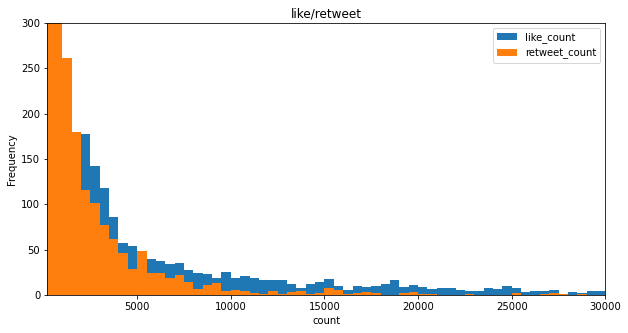

In [87]:
plt.figure(figsize = [10,5])
bins = np.arange(df3['like_count'].min() , df3['like_count'].max() + 500, 500)
df3.like_count.plot(kind='hist',  bins=bins )
bins = np.arange(df3['retweet_count'].min() , df3['retweet_count'].max() + 500, 500)
df3.retweet_count.plot(kind='hist', bins=bins )

plt.xlabel('count')
plt.legend()
plt.xlim(200,30000)
plt.ylim(0,300)
plt.title( 'like/retweet');

Observation :
it is clearly shown that the count of likes are more than the count of retweet .

## Insight 2
### Finding out the most Popular Dog Breed

In [88]:
df3.dog_type.value_counts()


None        1831
pupper       224
doggo         75
puppo         24
multiple      12
floofer        9
Name: dog_type, dtype: int64

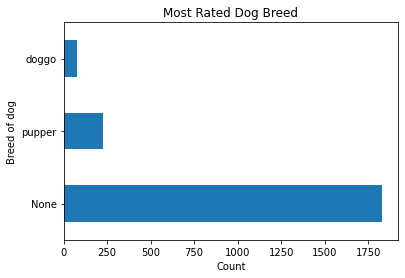

In [89]:
dog_breed = df3.groupby('dog_type').filter(lambda x: len(x) >= 25)

dog_breed['dog_type'].value_counts().plot(kind = 'barh')
plt.title('Most Rated Dog Breed')
plt.xlabel('Count')
plt.ylabel('Breed of dog');

Observation - We can see that most of the dogs do not have a breed. Out of the dogs who has a breed Pupper is the most frequent dog breed followed by doggo.

## Insight 3
### Plot of the Languages.¶

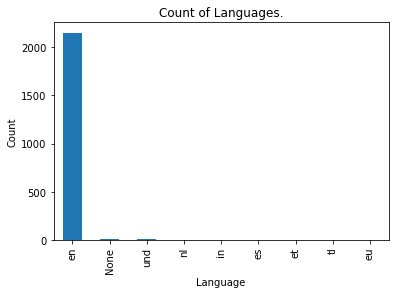

In [90]:
g = df3['lang'].value_counts()
g.plot(kind='bar')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Count of Languages.');

Observation - As you can see English is the most used language

## Insight 4 and Visualization
### Checking whether the highest retweets do recieve the most replys

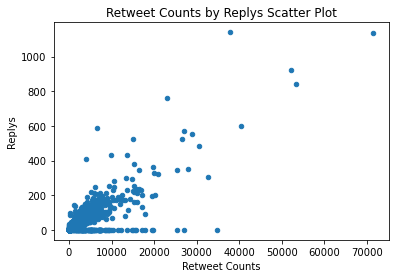

In [91]:
df3.plot(x='retweet_count', y='reply_count', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Replys')
plt.title('Retweet Counts by Replys Scatter Plot')

fig = plt.gcf()
fig.savefig('output3.png',bbox_inches='tight');

As you can see, higher the retweet count higher the number of replys get.